Loading: /content/df.csv
Initial shape: (9550, 5)
Columns: ['Million Plus Cities', 'Cause category', 'Cause Subcategory', 'Outcome of Incident', 'Count']


,Million Plus Cities,Cause category,Cause Subcategory,Outcome of Incident,Count
0,Agra,Traffic Control,Flashing Signal/Blinker,Greviously Injured,0.0
1,Agra,Traffic Control,Flashing Signal/Blinker,Minor Injury,0.0
2,Agra,Traffic Control,Flashing Signal/Blinker,Persons Killed,0.0
3,Agra,Traffic Control,Flashing Signal/Blinker,Total Injured,0.0
4,Agra,Traffic Control,Flashing Signal/Blinker,Total number of Accidents,0.0


No date/time parsed — skipping time-based features/plots.
No lat/lon detected — spatial plots will be skipped.
Found weather cols: []
Found road cols: []
Found light cols: []
Found factor cols: ['Cause category', 'Cause Subcategory']
Saved cleaned CSV to /content/df_cleaned.csv
Skipping spatial plots (no valid lat/lon).
None of [] found — skipping Top Weather Conditions
None of [] found — skipping Top Road / Surface Conditions
None of [] found — skipping Top Light Conditions


/tmp/ipython-input-2948567628.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


Saved /content/accident_figures/top_factors_Cause category.png


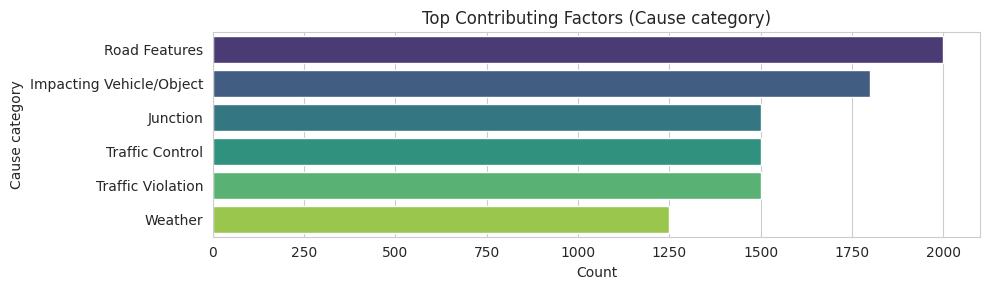


Finished. Cleaned CSV: /content/df_cleaned.csv | Figures in: /content/accident_figures


In [1]:
# Task 04: Traffic accident analysis — Colab-ready for /content/df.csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# ---------- Settings ----------
INPUT_CSV = "/content/df.csv"            # your provided path
CLEANED_CSV = "/content/df_cleaned.csv"
FIG_DIR = "/content/accident_figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- 1) Load dataset ----------
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"File not found: {INPUT_CSV}. Upload your df.csv to /content or change INPUT_CSV.")
print("Loading:", INPUT_CSV)
df = pd.read_csv(INPUT_CSV)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ---------- 2) Normalize column names ----------
df.columns = [c.strip() for c in df.columns]

# ---------- 3) Parse date/time ----------
# Common date/time column names to try
date_candidates = ['Date','date','DATE','Crash Date','CRASH_DATE','occurrence_date','occ_date','incident_date','Date/Time','date_time','CRASH_DATE_TIME','report_date']
time_candidates = ['Time','TIME','time','Crash Time','CRASH_TIME','time_occurred']
date_col = None
time_col = None

for c in date_candidates:
    if c in df.columns:
        date_col = c
        break
for c in time_candidates:
    if c in df.columns:
        time_col = c
        break

# Build occ_dt
if date_col:
    try:
        df['occ_dt'] = pd.to_datetime(df[date_col], errors='coerce')
    except:
        df['occ_dt'] = pd.to_datetime(df[date_col].astype(str), errors='coerce')
    # If date parsed but no hour and time_col present, combine
    if df['occ_dt'].isna().all() and time_col:
        combined = df[date_col].astype(str).fillna('') + ' ' + df[time_col].astype(str).fillna('')
        df['occ_dt'] = pd.to_datetime(combined, errors='coerce')
else:
    # Try to infer any column with datetime-like values
    for c in df.columns:
        if df[c].dtype == 'datetime64[ns]':
            df['occ_dt'] = df[c]
            date_col = c
            break
    if 'occ_dt' not in df.columns:
        for c in df.columns:
            if 'date' in c.lower() or 'time' in c.lower():
                try:
                    tmp = pd.to_datetime(df[c], errors='coerce')
                    if tmp.notna().sum() > 0:
                        df['occ_dt'] = tmp
                        date_col = c
                        break
                except:
                    pass

if 'occ_dt' in df.columns:
    df['occ_year']  = df['occ_dt'].dt.year
    df['occ_month'] = df['occ_dt'].dt.month
    df['occ_day']   = df['occ_dt'].dt.day
    df['occ_hour']  = df['occ_dt'].dt.hour
    df['occ_dow']   = df['occ_dt'].dt.day_name()
    print("Parsed datetime; null datetimes:", df['occ_dt'].isna().sum())
else:
    print("No date/time parsed — skipping time-based features/plots.")

# ---------- 4) Detect lat/lon ----------
lat_candidates = ['lat','latitude','LAT','Latitude','LATITUDE']
lon_candidates = ['lon','longitude','LON','Longitude','LONGITUDE','lng']
lat_col = next((c for c in df.columns if c in lat_candidates), None)
lon_col = next((c for c in df.columns if c in lon_candidates), None)

if lat_col and lon_col:
    df['lat'] = pd.to_numeric(df[lat_col], errors='coerce')
    df['lon'] = pd.to_numeric(df[lon_col], errors='coerce')
    print(f"Found lat/lon: {lat_col}, {lon_col}. Valid points:", df[['lat','lon']].dropna().shape[0])
else:
    print("No lat/lon detected — spatial plots will be skipped.")

# ---------- 5) Clean likely categorical columns ----------
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip().replace({'nan':'Unknown','None':'Unknown','': 'Unknown'})

# Heuristic lists
weather_cols = [c for c in df.columns if 'weather' in c.lower() or 'precip' in c.lower()]
road_cols = [c for c in df.columns if 'road' in c.lower() or 'surface' in c.lower() or 'roadcond' in c.lower()]
light_cols = [c for c in df.columns if 'light' in c.lower()]
factor_cols = [c for c in df.columns if 'contrib' in c.lower() or 'factor' in c.lower() or 'cause' in c.lower()]

print("Found weather cols:", weather_cols)
print("Found road cols:", road_cols)
print("Found light cols:", light_cols)
print("Found factor cols:", factor_cols)

# ---------- 6) Save cleaned CSV ----------
df.to_csv(CLEANED_CSV, index=False)
print("Saved cleaned CSV to", CLEANED_CSV)

# ---------- Helpers ----------
def savefig(fname):
    p = os.path.join(FIG_DIR, fname)
    plt.savefig(p, bbox_inches='tight', dpi=150)
    print("Saved", p)

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# ---------- 7) VISUALS ----------
# 7A: Monthly timeseries
if 'occ_dt' in df.columns:
    monthly = df.dropna(subset=['occ_dt']).set_index('occ_dt').resample('M').size()
    plt.figure(figsize=(12,4))
    plt.plot(monthly.index, monthly.values, marker='o')
    plt.title("Accidents per Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.tight_layout()
    savefig("accidents_per_month.png")
    plt.show()

# 7B: Hour of day
if 'occ_hour' in df.columns:
    counts = df['occ_hour'].value_counts().sort_index()
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts.index, y=counts.values, color='steelblue')
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.title("Accidents by Hour of Day")
    plt.tight_layout()
    savefig("accidents_by_hour.png")
    plt.show()

# 7C: Day of week
if 'occ_dow' in df.columns:
    dow_counts = df['occ_dow'].value_counts().reindex(dow_order).fillna(0)
    plt.figure(figsize=(10,4))
    sns.barplot(x=dow_counts.index, y=dow_counts.values, color='darkorange')
    plt.xticks(rotation=45)
    plt.xlabel("Day of Week")
    plt.ylabel("Count")
    plt.title("Accidents by Day of Week")
    plt.tight_layout()
    savefig("accidents_by_dow.png")
    plt.show()

# 7D: Heatmap (hour x dow)
if all(col in df.columns for col in ['occ_hour','occ_dow']):
    heat = df.dropna(subset=['occ_hour','occ_dow']).groupby(['occ_dow','occ_hour']).size().unstack(fill_value=0)
    heat = heat.reindex(dow_order).fillna(0)
    plt.figure(figsize=(12,4))
    sns.heatmap(heat, cmap='YlOrRd', norm=LogNorm(vmin=1, vmax=heat.values.max()), cbar_kws={'label':'Incidents (log scale)'})
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    plt.title("Accidents: Hour × Day-of-Week (log color)")
    plt.tight_layout()
    savefig("heatmap_hour_dow.png")
    plt.show()

# 7E: Spatial hotspots (hexbin and scatter)
if 'lat' in df.columns and 'lon' in df.columns and df['lat'].notna().any() and df['lon'].notna().any():
    sample = df.dropna(subset=['lat','lon'])
    if len(sample) > 50000:
        sample = sample.sample(50000, random_state=1)
    plt.figure(figsize=(8,6))
    plt.hexbin(sample['lon'], sample['lat'], gridsize=150, bins='log')
    plt.colorbar(label='log(count)')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Accident Hotspots (hexbin)")
    plt.tight_layout()
    savefig("hotspots_hexbin.png")
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(sample['lon'], sample['lat'], s=6, alpha=0.3)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Accident Locations (scatter)")
    plt.tight_layout()
    savefig("hotspots_scatter.png")
    plt.show()
else:
    print("Skipping spatial plots (no valid lat/lon).")

# 7F: Top contributing factors / weather / road
def plot_top(col_list, title, fname, top_n=15):
    for c in col_list:
        if c in df.columns:
            vc = df[c].fillna('Unknown').value_counts().head(top_n)
            plt.figure(figsize=(10, max(3,0.3*len(vc))))
            sns.barplot(x=vc.values, y=vc.index, palette='viridis')
            plt.xlabel("Count")
            plt.title(title + f" ({c})")
            plt.tight_layout()
            savefig(fname.replace('.png', f"_{c}.png"))
            plt.show()
            return
    print(f"None of {col_list} found — skipping {title}")

plot_top(weather_cols, "Top Weather Conditions", "top_weather.png")
plot_top(road_cols, "Top Road / Surface Conditions", "top_road.png")
plot_top(light_cols, "Top Light Conditions", "top_light.png")
plot_top(factor_cols, "Top Contributing Factors", "top_factors.png")

# 7G: Save summaries
if 'occ_dt' in df.columns:
    summary_month = df.dropna(subset=['occ_dt']).set_index('occ_dt').resample('M').size().rename('count').reset_index()
    summary_month.to_csv("/content/summary_by_month.csv", index=False)
    print("Saved summary_by_month.csv")
if 'occ_dow' in df.columns:
    df['occ_dow'] = pd.Categorical(df['occ_dow'], categories=dow_order, ordered=True)
    summary_dow = df['occ_dow'].value_counts().reindex(dow_order).fillna(0).rename_axis('day').reset_index(name='count')
    summary_dow.to_csv("/content/summary_by_dow.csv", index=False)
    print("Saved summary_by_dow.csv")
if 'occ_hour' in df.columns:
    summary_hour = df['occ_hour'].value_counts().sort_index().reset_index()
    summary_hour.columns = ['hour','count']
    summary_hour.to_csv("/content/summary_by_hour.csv", index=False)
    print("Saved summary_by_hour.csv")

print("\nFinished. Cleaned CSV:", CLEANED_CSV, "| Figures in:", FIG_DIR)
